In [2]:
!pip install shap
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 538.2/538.2 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 8.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283835 sha256=0e459d7d89c0e0dd99515da08758defe8f5ac63ad7a203aa87f75e8b00739006
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [3]:
import shap
import lime
from sklearn.model_selection import train_test_split

X,y = shap.datasets.adult()  # Numerical version of data
X_display, y_display = shap.datasets.adult(display=True)  # Human-readable data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)

In [4]:
from sklearn.ensemble import GradientBoostingClassifier

clf = GradientBoostingClassifier(n_estimators=100, random_state=10)
clf.fit(X_train.values, y_train)

GradientBoostingClassifier(random_state=10)

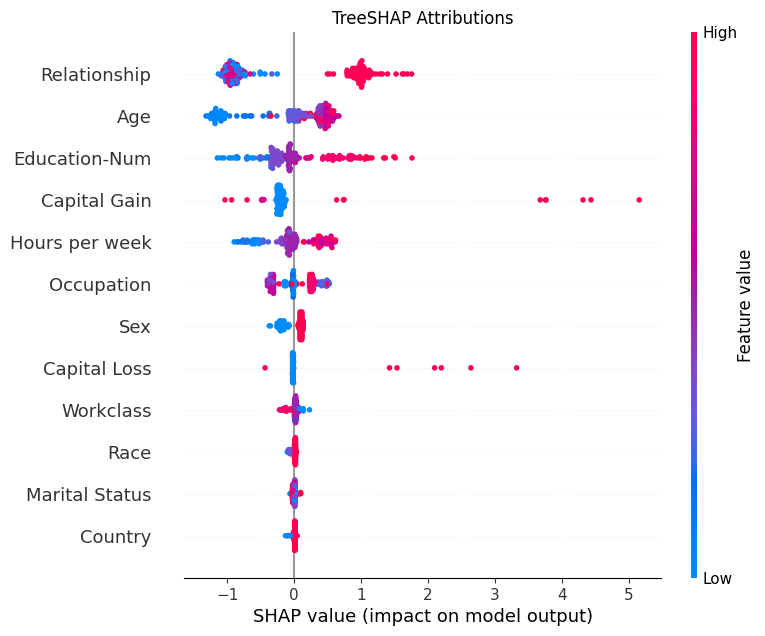

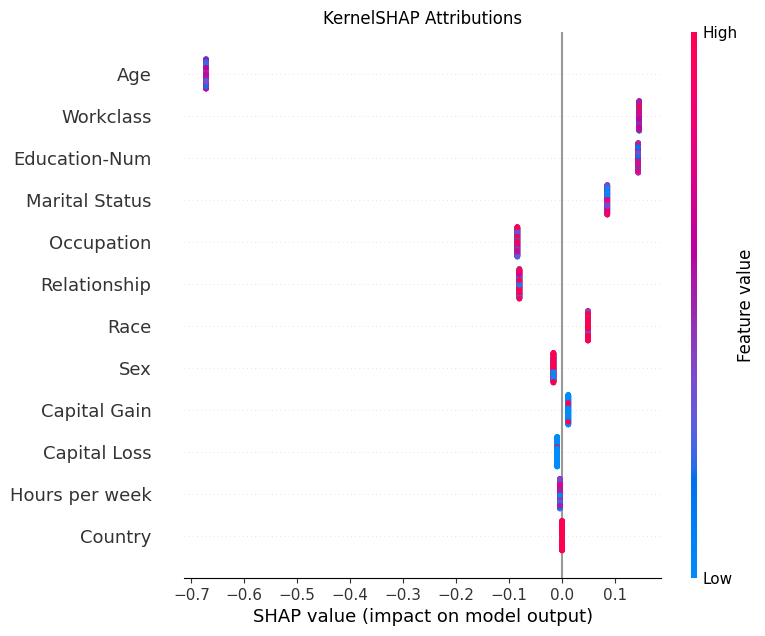

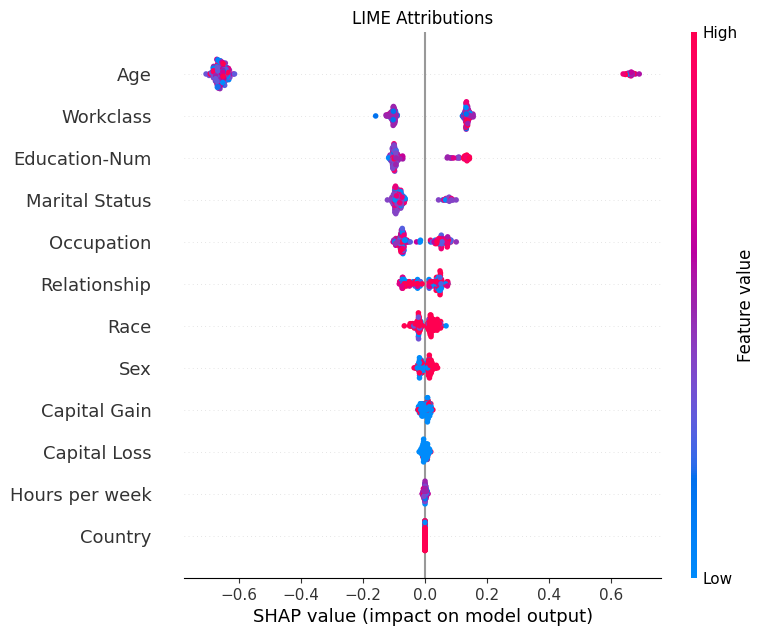

In [26]:
import shap
import lime.lime_tabular
import numpy as np
import matplotlib.pyplot as plt

# Assuming you have X_train, X_test, y_train, y_test, and clf (trained model)

explicands = X_test[:200]  # First 200 samples from the test set
baselines = X_test[-100:]  # Last 100 samples as baselines

# --- TreeSHAP ---
explainer = shap.TreeExplainer(clf, baselines)
tree_shap_attributions = explainer.shap_values(explicands)

shap.summary_plot(tree_shap_attributions, explicands, show=False)
plt.title("TreeSHAP Attributions")
plt.show()

# --- KernelSHAP ---
explainer = shap.KernelExplainer(clf.predict_proba, baselines)
# kernel_shap_attributions = explainer.shap_values(explicands)

kernel_shap_attributions = []

for explicand in explicands.values:
    attributions = explainer.shap_values(explicand)[1]
    # Extract only the attribution values (second element of each tuple)
    kernel_attribution = np.array([tup[1] for tup in attribution])
    kernel_shap_attributions.append(kernel_attribution)

kernel_shap_attributions = np.array(kernel_shap_attributions)

shap.summary_plot(kernel_shap_attributions, explicands, show=False)
plt.title("KernelSHAP Attributions")
plt.show()

# --- LIME ---
# (Explaining one instance at a time)
explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values, feature_names=X_train.columns)
lime_attributions = []

for explicand in explicands.values:
    attribution = explainer.explain_instance(explicand, clf.predict_proba, num_features=X_train.shape[1]).local_exp[1]
    # Extract only the attribution values (second element of each tuple)
    lime_attribution = np.array([tup[1] for tup in attribution])
    lime_attributions.append(lime_attribution)

lime_attributions = np.array(lime_attributions)

shap.summary_plot(lime_attributions, explicands, show=False)
plt.title("LIME Attributions")
plt.show()

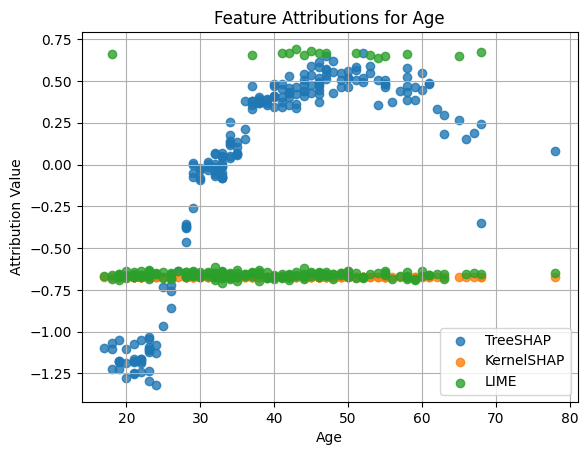

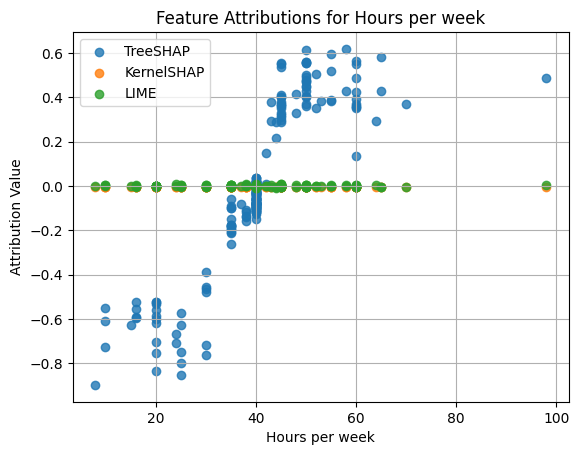

In [31]:
import matplotlib.pyplot as plt

features_to_plot = ["Age", "Hours per week"]
feature_names = X_train.columns

for feature in features_to_plot:
    # Get feature values and attributions for each method
    feature_values = explicands[feature]
    tree_shap_attributions_feature = tree_shap_attributions[:, feature_names.get_loc(feature)]
    kernel_shap_attributions_feature = kernel_shap_attributions[:, feature_names.get_loc(feature)]
    lime_attributions_feature = lime_attributions[:, feature_names.get_loc(feature)]

    # Create scatter plots for each method
    plt.figure()
    plt.scatter(feature_values, tree_shap_attributions_feature, label="TreeSHAP", alpha=0.8)
    plt.scatter(feature_values, kernel_shap_attributions_feature, label="KernelSHAP", alpha=0.8)
    plt.scatter(feature_values, lime_attributions_feature, label="LIME", alpha=0.8)

    plt.xlabel(feature)
    plt.ylabel("Attribution Value")
    plt.title(f"Feature Attributions for {feature}")
    plt.legend()
    plt.grid(True)
    plt.show()

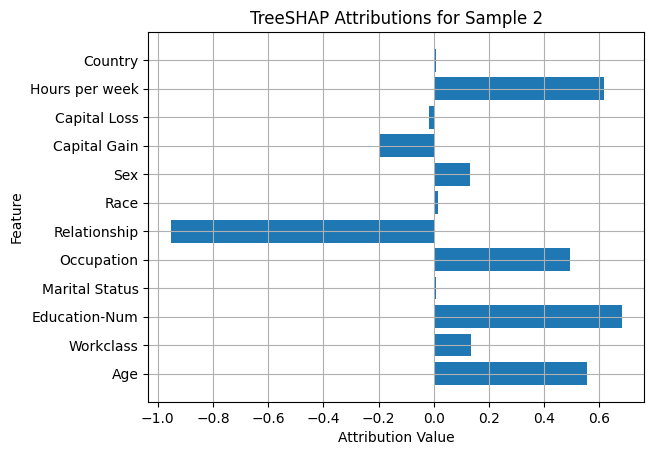

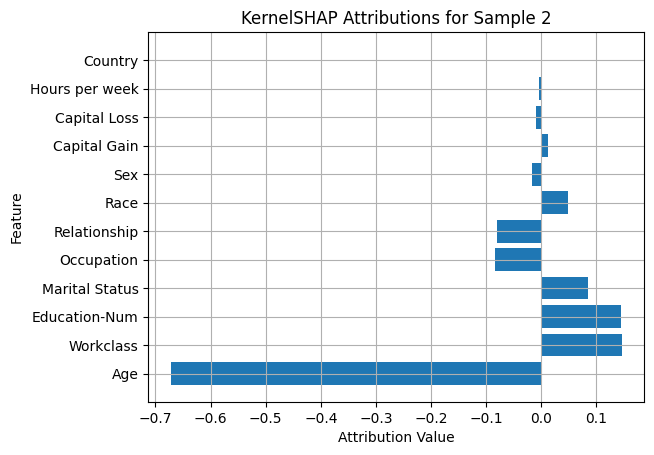

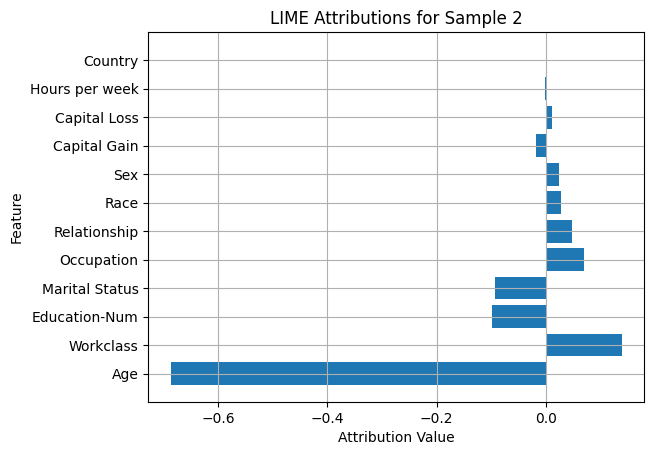

In [34]:
import matplotlib.pyplot as plt

sample_index = 1
explicand = X_test.iloc[sample_index]

# Get attributions for the sample
tree_shap_attributions_sample = tree_shap_attributions[sample_index, :]
kernel_shap_attributions_sample = kernel_shap_attributions[sample_index, :]
lime_attributions_sample = lime_attributions[sample_index, :]

# Create bar plots for each method
for attributions, method_name in zip([tree_shap_attributions_sample, kernel_shap_attributions_sample, lime_attributions_sample],
                                    ["TreeSHAP", "KernelSHAP", "LIME"]):
    plt.figure()
    plt.barh(feature_names, attributions)
    plt.xlabel("Attribution Value")
    plt.ylabel("Feature")
    plt.title(f"{method_name} Attributions for Sample {sample_index+1}")
    plt.grid(True)
    plt.show()

In [ ]:
import shap
import matplotlib.pyplot as plt
import numpy as np

# ... (previous code)

sample_index = 1
explicand = X_test.iloc[sample_index]

nsamples_list = [10, 100, 1000]
num_runs = 10

all_attributions = {nsamples: [] for nsamples in nsamples_list}

for nsamples in nsamples_list:
    for _ in range(num_runs):
        explainer = shap.KernelExplainer(clf.predict_proba, baselines)
        kernel_shap_attributions = []

        for explicand in explicands.values:
            attributions = explainer.shap_values(explicand)[1]
            # Extract only the attribution values (second element of each tuple)
            kernel_attribution = np.array([tup[1] for tup in attribution])
            kernel_shap_attributions.append(kernel_attribution)

        kernel_shap_attributions = np.array(kernel_shap_attributions)
        all_attributions[nsamples].append(kernel_shap_attributions)

# Calculate mean and standard deviation of attributions for each nsamples
mean_attributions = {nsamples: np.mean(attrs, axis=0) for nsamples, attrs in all_attributions.items()}
std_attributions = {nsamples: np.std(attrs, axis=0) for nsamples, attrs in all_attributions.items()}

# Bar plot with error bars
width = 0.2  # Width of the bars
x_pos = np.arange(len(feature_names))

for i, nsamples in enumerate(nsamples_list):
    plt.bar(x_pos + i * width, mean_attributions[nsamples], width,
            yerr=std_attributions[nsamples], label=f"{nsamples} Samples")

plt.xlabel("Attribution Value")
plt.ylabel("Feature")
plt.title("KernelSHAP Attributions with Varying Sample Sizes")
plt.xticks(x_pos + width, feature_names, rotation=90)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()